# Purpose
generate virtual detector images with single Bragg spots. This notebook will generate images of rystals with each radius.

## setup modules

In [1]:
import copy
import glob
import h5py
import json
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import LogNorm
import scipy.interpolate as interp
import os
import time
from typing import Tuple, Union, Dict

%matplotlib inline

## functions

In [2]:
def print_h5_tree(val, pre=''):
    if isinstance(val, h5py._hl.files.File):
        print(val.filename)

    items = len(val)
    for key, val in val.items():
        items -= 1
        if items == 0:
            # the last item
            if isinstance(val, h5py._hl.group.Group):
                print(pre + '└── ' + key)
                print_h5_tree(val, pre+'    ')
            else:
                print(pre + '└── ' + key)
        else:
            if isinstance(val, h5py._hl.group.Group):
                print(pre + '├── ' + key)
                print_h5_tree(val, pre+'│   ')
            else:
                print(pre + '├── ' + key)


def print_h5_tree_from_path(fpath: str):
    with h5py.File(fpath, "r") as tree:
        print_h5_tree(tree)

In [3]:
def get_fourier_modulus(fpath: str) -> np.ndarray:
    dst = None
    with h5py.File(fpath, "r") as tree:
        dst = tree['outputs']['main_outputs']['fourier_modulus'][()]
    return dst

In [4]:
def get_qrange(fpath: str) -> Tuple[Union[Dict[str, Union[Tuple[float], float]], float]]:
    qranges = {
        'x': None,  # (min, max)
        'y': None,  # (min, max)
    }
    dqs = {
        'x': None,
        'y': None,
    }
    q_spot_expected = None
    with h5py.File(fpath, "r") as tree:
        qranges['x'] = (
            tree['outputs']['momentum_space']['momentum_x'][()].min(),
            tree['outputs']['momentum_space']['momentum_x'][()].max()
        )
        qranges['y'] = (
            tree['outputs']['momentum_space']['momentum_y'][()].min(),
            tree['outputs']['momentum_space']['momentum_y'][()].max()
        ) 

        dqs['x'] = np.diff(sorted(np.unique(tree['outputs']['momentum_space']['momentum_x'][()])))[0]
        dqs['y'] = np.diff(sorted(np.unique(tree['outputs']['momentum_space']['momentum_y'][()])))[0]

        q_spot_expected = 2. * np.pi / tree['input_parameters']['target']['unit_cell_length'][()] * \
            np.linalg.norm(tree['input_parameters']['target']['miller_index'][()])
    
    return qranges, dqs, q_spot_expected

In [5]:
def load_spot_positions(fpath: str):
    pos_spot_ranges = {  # (min, max)
        'x': None,
        'y': None
    }
    pos_spot_peak = {
        'x': None,
        'y': None
    }
    with h5py.File(factor_result_path, 'r') as tree:
        pos_spot_ranges['x'] = tree['outputs']['positions']['pos_spot_range_x'][()]
        pos_spot_ranges['y'] = tree['outputs']['positions']['pos_spot_range_y'][()]
        pos_spot_peak['x'] = tree['outputs']['positions']['pos_spot_peak_x'][()]
        pos_spot_peak['y'] = tree['outputs']['positions']['pos_spot_peak_y'][()]
    
    return pos_spot_ranges, pos_spot_peak


def get_spot_qrange(pos_spot_ranges, dqs, qranges):
    pos_spot_qranges = {}
    for key in pos_spot_ranges.keys():
        pos_spot_qranges[key] = qranges[key][0] + np.arange(pos_spot_ranges[key][0], pos_spot_ranges[key][1] + 1) * dqs[key]

    pos_spot_peak_q = {}
    for key in pos_spot_peak.keys():
        pos_spot_peak_q[key] = qranges[key][0] + pos_spot_peak[key] * dqs[key]
    
    return pos_spot_qranges, pos_spot_peak_q

In [6]:
def generate_spot_positions(
    intensity_map: np.ndarray, pos_spot_peak: dict,
    sigma_r: float, n_shots: int
):
    r_spot = np.random.normal(mu_r, sigma_r, n_shots)
    theta_spot = np.random.uniform(0.0, 2. * np.pi, n_shots)
    x = r_spot * np.sin(theta_spot) + intensity_map.shape[1]//2
    y = r_spot * np.cos(theta_spot) + intensity_map.shape[0]//2
    return x, y

In [7]:
def generate_image(
    intensity_map: np.ndarray, x: int, y: int,
    pos_spot_ranges: dict, pos_spot_peak: dict
) -> np.ndarray:
    image = np.zeros(intensity_map.shape)
    shift_x =  x - pos_spot_peak['x']
    shift_y =  y - pos_spot_peak['y']
    image[
        pos_spot_ranges['y'][0] + shift_y:pos_spot_ranges['y'][1] + shift_y + 1,
        pos_spot_ranges['x'][0] + shift_x:pos_spot_ranges['x'][1] + shift_x + 1,
    ] = intensity_map[
        pos_spot_ranges['y'][0]:pos_spot_ranges['y'][1]+1,
        pos_spot_ranges['x'][0]:pos_spot_ranges['x'][1]+1
    ].copy()
    return image

In [8]:
def add_params(group, key, values):
    if values.get('value') is not None:
        _ = group.create_dataset(key, data=values['value'])
        return group
    group_ = group.create_group(f'{key}')
    for key_, values_ in values.items():
        group_ = add_params(group_, key_, values_)
    return group


def output(dstpath: str, parameters: dict, outputs: dict):
    with h5py.File(dstpath, 'w') as tree:
        # parameters
        tree = add_params(tree, 'input_parameters', parameters)

        # outputs
        tree = add_params(tree, 'outputs', outputs)

## paths

In [9]:
# src
srcdir = "../output_data/01_simulation/"
srclist = sorted(glob.glob(os.path.join(srcdir, "*.h5")))

# normalization factor
factor_result_path = "../output_data/02_normalization/factor.h5"

In [10]:
srclist

['../output_data/01_simulation/fourier_modulus_R10.40A.h5',
 '../output_data/01_simulation/fourier_modulus_R100.80A.h5',
 '../output_data/01_simulation/fourier_modulus_R112.00A.h5',
 '../output_data/01_simulation/fourier_modulus_R15.60A.h5',
 '../output_data/01_simulation/fourier_modulus_R20.80A.h5',
 '../output_data/01_simulation/fourier_modulus_R26.00A.h5',
 '../output_data/01_simulation/fourier_modulus_R31.20A.h5',
 '../output_data/01_simulation/fourier_modulus_R36.40A.h5',
 '../output_data/01_simulation/fourier_modulus_R41.60A.h5',
 '../output_data/01_simulation/fourier_modulus_R46.80A.h5',
 '../output_data/01_simulation/fourier_modulus_R5.20A.h5',
 '../output_data/01_simulation/fourier_modulus_R52.00A.h5',
 '../output_data/01_simulation/fourier_modulus_R56.00A.h5',
 '../output_data/01_simulation/fourier_modulus_R67.20A.h5',
 '../output_data/01_simulation/fourier_modulus_R78.40A.h5',
 '../output_data/01_simulation/fourier_modulus_R89.60A.h5']

## load the normalization factor

In [11]:
factor = None
with h5py.File(factor_result_path, 'r') as tree:
    factor = tree['outputs']['main_outputs']['normalization_factor'][()]

## get the index corresponding to the crystal with the maximum radius

In [12]:
radii = []
for fpath in srclist:
    with h5py.File(fpath, "r") as tree:
        radii.append(tree['input_parameters']['target']['crystal_characteristic_length'][()])

radii = np.array(radii)

In [13]:
ind_radii_max = np.where(radii == radii.max())[0][0]

## get q-ranges

In [14]:
qranges, dqs, q_spot_expected = get_qrange(srclist[ind_radii_max])

## load spot positions

In [15]:
pos_spot_ranges, pos_spot_peak = load_spot_positions(factor_result_path)
pos_spot_qranges, pos_spot_peak_q = get_spot_qrange(pos_spot_ranges, dqs, qranges)

## parameters

In [16]:
parameters_format = {
    'source': {
        'srcpath': {
            'value': None,
            'unit': 'none',
            'type': 'str'
        },
        'factor_result_path': {
            'value': factor_result_path,
            'unit': 'none',
            'type': 'str'
        }
    },
    'random_seed': {
        'value': None,
        'unit': 'none',
        'type': 'int'
    },
    'image': {
        'number_of_images': {
            'value': 100,
            'unit': 'none',
            'type': 'int'
        },
        'radius_std': {
            'value': 2.0,
            'unit': 'pixel',
            'type': 'float'
        }
    },
    'detector_noise': {
        'mean': {
            'value': 0.0,
            'unit': 'photons',
            'type': 'float'
        },
        'std': {
            'value': 0.1,
            'unit': 'photons',
            'type': 'float'
        }
    }
}

In [17]:
outputs_format = {
    'main_outputs': {
        'images': {
            'value': None,
            'unit': 'photons',
            'type': 'numpy.ndarray(float)'
        }
    },
    'expected_positions': {
        'x': {
            'value': None,
            'unit': 'pixel',
            'type': 'tuple(float)'
        },
        'y': {
            'value': None,
            'unit': 'pixel',
            'type': 'tuple(float)'
        },
    }
}

In [18]:
fname = 'images_R{0:.2f}A_{1}shots.h5'
outputdir = '../output_data/03_calculate_exp_data'

if not os.path.exists(outputdir):
    os.makedirs(outputdir)

# main

In [19]:
seed_start = 1023
seed_step = 10

seeds = np.arange(seed_start, seed_start + seed_step * len(srclist), seed_step).astype(np.int64)

In [20]:
st = time.time()
for ii, fpath in enumerate(srclist):
    print("target:", fpath)
    # update parameters
    parameters = copy.deepcopy(parameters_format)
    parameters['source']['srcpath']['value'] = fpath
    parameters['random_seed']['value'] = seeds[ii]
    
    # get parameters
    sigma_r = parameters['image']['radius_std']['value']
    n_shots = parameters['image']['number_of_images']['value']
    mu_bg = parameters['detector_noise']['mean']['value']
    sigma_bg = parameters['detector_noise']['std']['value']
    
    # laod the intensity map and execute normalization
    intensity = get_fourier_modulus(fpath)
    intensity = factor * np.abs(intensity)**2
    mu_r = ((pos_spot_peak['x'] - intensity.shape[1]//2)**2 + \
    (pos_spot_peak['y'] - intensity.shape[0]//2)**2)**0.5
    
    # generate spot positions
    np.random.seed(seeds[ii])
    x, y = generate_spot_positions(intensity, pos_spot_peak, sigma_r, n_shots)
    
    # generate images
    images = np.zeros((n_shots, intensity.shape[0], intensity.shape[1]))
    for ii in range(n_shots):
        image_ = generate_image(
            intensity, int(x[ii]), int(y[ii]),
            pos_spot_ranges, pos_spot_peak
        )

        # add noise
        images[ii] = np.random.poisson(image_).astype(np.float64) + np.random.normal(mu_bg, sigma_bg, image_.shape)
    
    # set the output path
    raduis_ = None
    with h5py.File(fpath, "r") as tree:
        radius_ = tree['input_parameters']['target']['crystal_characteristic_length'][()]
    dstpath = os.path.join(outputdir, fname.format(radius_, n_shots))

    # output the results
    outputs = copy.deepcopy(outputs_format)
    outputs['main_outputs']['images']['value'] = images
    outputs['expected_positions']['x']['value'] = x
    outputs['expected_positions']['y']['value'] = y
    output(dstpath, parameters, outputs)
    print(f"elapsed time: {time.time() - st:.2f} sec.")
    # break

target: ../output_data/01_simulation/fourier_modulus_R10.40A.h5
elapsed time: 1.28 sec.
target: ../output_data/01_simulation/fourier_modulus_R100.80A.h5
elapsed time: 2.58 sec.
target: ../output_data/01_simulation/fourier_modulus_R112.00A.h5
elapsed time: 3.86 sec.
target: ../output_data/01_simulation/fourier_modulus_R15.60A.h5
elapsed time: 5.17 sec.
target: ../output_data/01_simulation/fourier_modulus_R20.80A.h5
elapsed time: 6.47 sec.
target: ../output_data/01_simulation/fourier_modulus_R26.00A.h5
elapsed time: 7.87 sec.
target: ../output_data/01_simulation/fourier_modulus_R31.20A.h5
elapsed time: 9.42 sec.
target: ../output_data/01_simulation/fourier_modulus_R36.40A.h5
elapsed time: 10.80 sec.
target: ../output_data/01_simulation/fourier_modulus_R41.60A.h5
elapsed time: 12.15 sec.
target: ../output_data/01_simulation/fourier_modulus_R46.80A.h5
elapsed time: 13.73 sec.
target: ../output_data/01_simulation/fourier_modulus_R5.20A.h5
elapsed time: 15.10 sec.
target: ../output_data/01_s

## chech the outputs

In [21]:
dstlist = sorted(glob.glob(os.path.join(outputdir, "*.h5")))

len(dstlist)

16

In [22]:
print_h5_tree_from_path(dstlist[0])

../output_data/03_calculate_exp_data/images_R10.40A_100shots.h5
├── input_parameters
│   ├── detector_noise
│   │   ├── mean
│   │   └── std
│   ├── image
│   │   ├── number_of_images
│   │   └── radius_std
│   ├── random_seed
│   └── source
│       ├── factor_result_path
│       └── srcpath
└── outputs
    ├── expected_positions
    │   ├── x
    │   └── y
    └── main_outputs
        └── images


### plot the summed image

In [23]:
outputdir_img = '../output_data/03_calculate_exp_data_img'

if not os.path.exists(outputdir_img):
    os.makedirs(outputdir_img)

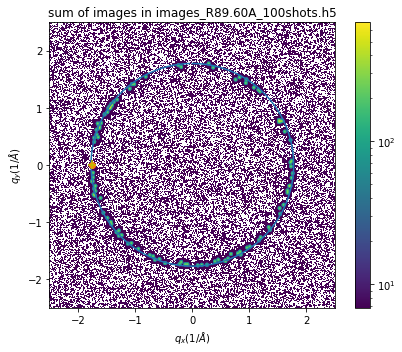

In [24]:
extent = [
    qranges['x'][0] - dqs['x'] / 2.0, qranges['x'][1] + dqs['x'] / 2.0,
    qranges['y'][0] - dqs['y'] / 2.0, qranges['y'][1] + dqs['y'] / 2.0
]  # (left, right, bottom, top)

plt.figure(figsize=(6,5))
for fpath in dstlist:
    fname = os.path.basename(fpath)
    image = None
    with h5py.File(fpath, 'r') as tree:
        images_ = tree['outputs']['main_outputs']['images'][()]
        image = images_.sum(axis=0)

    # show the modulus
    plt.clf()
    plt.subplot(111)
    plt.imshow(
        image, origin='lower', extent=extent,
        norm=LogNorm(vmin=image.max() / 1e2, vmax=image.max())
    )

    # plot a circle with a radius of $2\pi / d(111)$
    theta = np.arange(0., 2.*np.pi, np.pi/100)
    plt.plot(q_spot_expected * np.sin(theta), q_spot_expected * np.cos(theta), '-')

    # plot a peak position and cross lines at the peak
    plt.plot(pos_spot_peak_q['x'], pos_spot_peak_q['y'], "o")
    plt.hlines(
        pos_spot_peak_q['y'], pos_spot_qranges['x'][0], pos_spot_qranges['x'][-1],
        colors='y'
    )
    plt.vlines(
        pos_spot_peak_q['x'], pos_spot_qranges['y'][0], pos_spot_qranges['y'][-1],
        colors='y'
    )

    plt.xlabel('$q_x (1/\AA$)')
    plt.ylabel('$q_y (1/\AA$)')
    plt.title(f'sum of images in {fname}')

    # plt.xlim(pos_spot_qranges['x'][0], pos_spot_qranges['x'][-1])
    # plt.ylim(pos_spot_qranges['y'][0], pos_spot_qranges['y'][-1])
    plt.colorbar()

    plt.tight_layout()
    plt.savefig(
        os.path.join(outputdir_img, fname.replace('h5', 'png')),
        bbox_inches='tight', pad_inches=0.2
    )